# Importazione librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
import numpy as np
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
from typing import Callable

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random
import os

In [2]:
pd.options.display.max_columns = None

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Function

In [4]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [5]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

In [6]:
# def liquidity_out_function(current_liquidity: float, coef_liquidity_out:float, variation_percent_ma: float) -> float:
#     """
#     Funzione che calcola la nuova percentuale di liquidità desiderata quando 
#     TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
#     Aumentiamo la liquidità in base al modulo della variazione percentuale 
#     della media mobile della variazione percentuale del prezzo medio.
#     """
#     new_liquidity = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
#     # Limitiamo tra 0 e 1
#     return min(max(new_liquidity, 0), 1)

In [7]:
# def liquidity_in_function(current_liquidity: float, coef_liquidity_in: float, variation_percent_ma: float) -> float:
#     """
#     Funzione che calcola la nuova percentuale di liquidità desiderata quando
#     ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
#     Riduciamo la liquidità in base alla variazione percentuale 
#     della media mobile della variazione percentuale del prezzo medio.
#     """
#     # if variation_percent_ma in [0, None] and coef_liquidity_in == np.inf:
#     #     return 0
    
#     new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
#     # Limitiamo tra 0 e 1
#     return min(max(new_liquidity, 0), 1)

In [8]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

# Strategia

In [9]:
def portfolio_value(prices_row: pd.Series, quantities_dict: dict, liquidity_amount: float) -> float:
    """
    Calcola il valore totale del portafoglio (sommando le crypto e la liquidità).
    """
    total = liquidity_amount
    for c in quantities_dict.keys():
        total += quantities_dict[c] * prices_row[c]
    return total

In [10]:
def trova_massimi_minimi_locali(series: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dati i valori di 'series', individua i massimi e minimi locali secondo la regola:
    
    - Per i = 0 (primo elemento), se series[0] > series[1], allora series[0] è un massimo locale.
      Se series[0] <= series[1], allora series[0] è un minimo locale.
    - Per 0 < i < len(series) - 1:
        * massimi se series[i-1] < series[i] > series[i+1]
        * minimi se series[i-1] > series[i] < series[i+1]
    - L'ultimo elemento (i = len(series)-1) non viene considerato per definizione.
    
    Ritorna due pd.Series (massimi, minimi) dove i valori sono NaN se non è un estremo locale,
    oppure il valore della series se è un massimo/minimo locale.
    """
    n = len(series)
    
    massimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    minimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    
    if n == 0 or n == 1:
        # Con un solo punto o nessuno, non possiamo definire un massimo o minimo locale
        return massimi, minimi
    
    # Gestione del primo elemento (i=0)
    if n >= 2:
        if series.iloc[0] > series.iloc[1]:
            massimi.iloc[0] = series.iloc[0]
        else:
            minimi.iloc[0] = series.iloc[0]
    
    # Gestione degli elementi intermedi (1 .. n-2)
    for i in range(1, n-1):
        if (series.iloc[i-1] < series.iloc[i] > series.iloc[i+1]):
            massimi.iloc[i] = series.iloc[i]
        elif (series.iloc[i-1] > series.iloc[i] < series.iloc[i+1]):
            minimi.iloc[i] = series.iloc[i]
    
    # L'ultimo elemento (i = n-1) non lo consideriamo come massimo o minimo locale
    
    return massimi, minimi

In [11]:
def trova_ultimo_estremo_locale(series: pd.Series,
                               massimi: pd.Series,
                               minimi: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dato un vettore 'series' e i suoi 'massimi' e 'minimi' locali (come restituiti da
    trova_massimi_minimi_locali), costruisce due Series:
      - last_ext_type: 'max' o 'min' (oppure None/NaN se non c'è stato ancora un estremo)
      - last_ext_value: valore dell'ultimo estremo locale incontrato finora (NaN se nessuno)
    
    Esempio: per i=0, last_ext_type[0] è 'max' se massimi[0] non è NaN, 
             'min' se minimi[0] non è NaN, altrimenti None.
    """
    n = len(series)
    last_ext_type_arr = [None]*n
    last_ext_value_arr = [None]*n
    
    current_type = None
    current_value = None
    
    for i in range(n):
        if not pd.isna(massimi.iloc[i]):
            current_type = 'max'
            current_value = massimi.iloc[i]
        elif not pd.isna(minimi.iloc[i]):
            current_type = 'min'
            current_value = minimi.iloc[i]
        
        last_ext_type_arr[i] = current_type
        last_ext_value_arr[i] = current_value
    
    last_ext_type = pd.Series(last_ext_type_arr, index=series.index, dtype=object)
    last_ext_value = pd.Series(last_ext_value_arr, index=series.index, dtype=float)
    return last_ext_type, last_ext_value

In [12]:
def func_liquidity_out(current_liquidity: float,
                           coef_liquidity_out: float,
                           variation_percent_ma: float) -> float:
    """
    Aumenta la liquidità in base al coefficiente e alla variazione percentuale (assoluta).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_out == np.inf and variation_percent_ma == 0:
        return 1

    new_liquidity_pct = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    return min(max(new_liquidity_pct, 0), 1)

In [13]:
def func_liquidity_in(current_liquidity: float,
                          coef_liquidity_in: float,
                          variation_percent_ma: float) -> float:
    """
    Riduce la liquidità in base al coefficiente e alla variazione percentuale (positiva).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_in == np.inf and variation_percent_ma == 0:
        return 0

    new_liquidity_pct = current_liquidity - coef_liquidity_in * variation_percent_ma
    return min(max(new_liquidity_pct, 0), 1)

In [14]:
def param_str(x):
    """Restituisce il nome se x è una funzione, altrimenti la stringa normale."""
    if callable(x):
        return x.__name__  # così vedrò "ma_prices", "mstd_returns_prices", ecc.
    return str(x)

def grid_search_rebalancing(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        global mini_grid_search_activated
        mini_grid_search_activated = False # Ho dovuto creare 2 function distinte grid_search_rebalancing e mini_grid_search_rebalancing perchè in quella mini devo lasciare mini_grid_search_activated com'è, mentre nella grid search normale è importante reinizializzare mini_grid_search_activated a False prima di ogni combinazione che testo
        display_dict = {k: param_str(v) for k,v in params.items()}
        print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
        print(f"Parametri: {display_dict}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy( # type: ignore
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['timeframe_grid_search'],
                params['mobile_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search'],
                params['func_monitor']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df


def mini_grid_search_rebalancing(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        display_dict = {k: param_str(v) for k,v in params.items()}
        print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
        print(f"Parametri: {display_dict}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy( # type: ignore
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['timeframe_grid_search'],
                params['mobile_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search'],
                params['func_monitor']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df

In [15]:
# Funzione che calcola la media mobile delle variazioni percentuali dei prezzi
def ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = MA delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo media mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = std mobile delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile dei prezzi
def ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = MA del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo media mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile dei prezzi
def mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = std mobile del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile dei prezzi
def mstd_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile delle variazioni percentuali dei prezzi
def mstd_ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def ma_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile dei prezzi
def mstd_ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile dei prezzi
def ma_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

## Strategia principale

In [16]:
mini_grid_search_activated = False

In [17]:
def simulate_trading_strategy(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    timeframe: int,
    timeframe_grid_search: int,
    mobile_window: int,
    weighting_factor: float,
    coef_liquidity_out: float,
    coef_liquidity_in: float,
    dynamical_variables: dict,
    window_grid_search: int,
    func_monitor: Callable
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto. Logica:
      (stessa descrizione di prima, invariata)
    """
    global mini_grid_search_activated # Variabile di supporto, non è un parametro della strategia

    if timeframe_grid_search == -1:
        timeframe_grid_search = timeframe

    # =========== PRECALCOLI UNA TANTUM ===========

    # 1) Calcoliamo le metriche con la function specificata
    monitor_df = func_monitor(crypto_prices, mobile_window).copy()
    monitor_df.sort_index(inplace=True)  # Sort una volta sola

    # 2) Troviamo massimi/minimi locali su 'avg_metric'
    massimi_avg, minimi_avg = trova_massimi_minimi_locali(monitor_df['avg_metric'])
    ltype_avg, lval_avg = trova_ultimo_estremo_locale(monitor_df['avg_metric'], massimi_avg, minimi_avg)
    monitor_df["last_ext_type_avg"] = ltype_avg
    monitor_df["last_ext_value_avg"] = lval_avg

    # 3) Per ogni crypto, troviamo massimi/minimi su 'metric_{crypto}'
    crypto_list = list(crypto_prices.columns)
    for c in crypto_list:
        mc = f"metric_{c}"
        massimi_c, minimi_c = trova_massimi_minimi_locali(monitor_df[mc])
        lt_c, lv_c = trova_ultimo_estremo_locale(monitor_df[mc], massimi_c, minimi_c)
        monitor_df[f"last_ext_type_{c}"] = lt_c
        monitor_df[f"last_ext_value_{c}"] = lv_c

    # 4) 'sub_metric_up'
    up_bool_df = pd.DataFrame(False, index=monitor_df.index, columns=crypto_list)
    for c in crypto_list:
        up_bool_df[c] = (monitor_df[f"last_ext_type_{c}"] == 'min')

    arr_metrics = monitor_df[[f"metric_{c}" for c in crypto_list]].values
    arr_up_bool = up_bool_df.values

    sum_up = (arr_metrics * arr_up_bool).sum(axis=1)
    count_up = arr_up_bool.sum(axis=1)

    sub_metric_up = np.full(len(monitor_df), np.nan, dtype=float)
    with np.errstate(invalid='ignore', divide='ignore'):
        sub_metric_up = sum_up / count_up
    monitor_df["sub_metric_up"] = sub_metric_up

    monitor_df["sub_return_up"] = pd.Series(sub_metric_up, index=monitor_df.index).pct_change()
    monitor_df["MA_sub_return_up"] = monitor_df["sub_return_up"].rolling(window=mobile_window).mean()

    massimi_sub, minimi_sub = trova_massimi_minimi_locali(monitor_df["MA_sub_return_up"])
    ltype_sub, lval_sub = trova_ultimo_estremo_locale(monitor_df["MA_sub_return_up"], massimi_sub, minimi_sub)
    monitor_df["last_ext_type_sub_up"] = ltype_sub
    monitor_df["last_ext_value_sub_up"] = lval_sub

    # Rename per comodità
    prices_df = monitor_df  # useremo 'prices_df' nel loop

    # =========== INIZIALIZZAZIONE PORTAFOGLIO ===========

    if 'liquidity' not in initial_allocations:
        initial_allocations['liquidity'] = 0.0

    s_ = sum(initial_allocations.values())
    if not np.isclose(s_, 1.0, atol=1e-7):
        if abs(s_ - 1.0) > 1e-3:
            raise ValueError(f"La somma delle allocazioni iniziali deve essere ~1.0, invece e' {s_}")
        # Rinormalizziamo
        for k in initial_allocations:
            initial_allocations[k] /= s_

    crypto_alloc = [k for k in initial_allocations if k.lower() != "liquidity"]
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError("Allocazioni non sommano a 1.0")

    current_quantities = {c: 0.0 for c in crypto_alloc}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0.0)
    if np.isclose(current_liquidity, 0.0):
        current_liquidity = 0.0

    # Prezzi/metrica del primo giorno
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_alloc]
    for c in crypto_alloc:
        perc = initial_allocations[c]
        p = first_row[c]
        cap = initial_liquidity * perc
        if pd.notna(p) and p != 0:
            current_quantities[c] = cap / p
        else:
            current_quantities[c] = 0.0

    # =========== LOOP PRINCIPALE ============

    records = []
    idx_array = prices_df.index.to_list()
    N = len(idx_array)

    for i, dt in enumerate(idx_array):
        # Preleviamo con un'unica operazione la riga
        row_data = prices_df.iloc[i]
        row_prices = row_data[crypto_alloc]  # prezzi/valori di c in questa riga
        pv = portfolio_value(row_prices, current_quantities, current_liquidity)

        if np.isclose(current_liquidity, 0.0):
            current_liquidity = 0.0

        # Creiamo il record
        rec = {
            "timestamp": dt,
            "liquidity": current_liquidity,
            "portfolio_value": pv,
            "avg_metric":         row_data["avg_metric"],
            "sub_metric_up":      row_data["sub_metric_up"],
            "sub_return_up":      row_data["sub_return_up"],
            "MA_sub_return_up":   row_data["MA_sub_return_up"],
        }
        for c in crypto_alloc:
            price_c = row_prices[c]
            qty_c   = current_quantities[c]
            rec[f"price_{c}"] = price_c
            rec[f"qty_{c}"]   = qty_c
            rec[f"value_{c}"] = (price_c * qty_c) if pd.notna(price_c) else np.nan

            rec[f"metric_{c}"]          = row_data[f"metric_{c}"]
            rec[f"last_ext_type_{c}"]   = row_data[f"last_ext_type_{c}"]
            rec[f"last_ext_value_{c}"]  = row_data[f"last_ext_value_{c}"]

        rec["last_ext_type_avg"]    = row_data["last_ext_type_avg"]
        rec["last_ext_value_avg"]   = row_data["last_ext_value_avg"]
        rec["last_ext_type_sub_up"] = row_data["last_ext_type_sub_up"]
        rec["last_ext_value_sub_up"] = row_data["last_ext_value_sub_up"]

        records.append(rec)

        # print('Ora mini_grid_search_activated vale:', mini_grid_search_activated)
        # =========== Ribilanciamento =============
        if i > 0 and i % timeframe == 0 and not mini_grid_search_activated or i > 0 and i % timeframe_grid_search == 0 and mini_grid_search_activated:
            # [A] Grid search dinamica (se serve)
            if dynamical_variables:
                print("Valore attuale del portafoglio totale:", pv)
                local_dynvars = deepcopy(dynamical_variables)
                default_parameters = {
                    'coef_liquidity_in': coef_liquidity_in,
                    'coef_liquidity_out': coef_liquidity_out,
                    'dynamical_variables': {},
                    'func_monitor': func_monitor,
                    'mobile_window': mobile_window,
                    'timeframe': timeframe,
                    'timeframe_grid_search': timeframe_grid_search, # Anzichè passare lo stesso timeframe della strategia principale, nella mini grid search passo più in generale timeframe_grid_search
                    'weighting_factor': weighting_factor,
                    'window_grid_search': window_grid_search
                }
                for pname in default_parameters:
                    if pname not in local_dynvars:
                        local_dynvars[pname] = [default_parameters[pname]]
                if len(local_dynvars) != len(default_parameters):
                    raise ValueError("dynamical_variables ha feature inesistenti.")
                
                sort_quantity = 'fattore_rendimento_totale'
                param_grid = local_dynvars
                grid_params = list(ParameterGrid(param_grid))

                skip_conditions = [False]*len(grid_params)
                window_grid_search = min(window_grid_search, i)

                # Ricostruisco l'allocazione "iniziale" di window_grid_search giorni fa
                past_rec = records[i - window_grid_search]
                temp_init_allocs = {
                    c: (past_rec['liquidity']/past_rec['portfolio_value'] if c=='liquidity'
                        else past_rec[f"value_{c}"]/past_rec['portfolio_value'])
                    for c in initial_allocations.keys()
                }
                print("temp_initial_allocations:", temp_init_allocs)
                print(f"Sto per fare la grid search del giorno {dt} (i={i})...")

                # Esegui la mini-grid search
                sub_prices = crypto_prices.iloc[i-window_grid_search : i]
                portaf_iniz = records[i - window_grid_search]['portfolio_value']
                mini_grid_search_activated = True
                risultati_df_ordinati = mini_grid_search_rebalancing(
                    sub_prices, grid_params, temp_init_allocs, portaf_iniz,
                    skip_conditions, sort_quantity
                )
                mini_grid_search_activated = False
                best_row = risultati_df_ordinati.iloc[0]
                display_best_row = {k: param_str(v) for k,v in best_row.items()}
                print(f"Migliori parametri (e target) trovati per il periodo {idx_array[i-window_grid_search]}-{idx_array[i]}:\n{display_best_row}")

                coef_liquidity_in, coef_liquidity_out, func_monitor, mobile_window, timeframe, weighting_factor, window_grid_search = \
                    best_row['coef_liquidity_in'], best_row['coef_liquidity_out'], best_row['func_monitor'], best_row['mobile_window'], best_row['timeframe'], best_row['weighting_factor'], \
                    best_row['window_grid_search']

            # [B] Controllo all_down / some_up
            all_down = True
            at_least_one_up = False

            for c in crypto_alloc:
                ext_type = row_data[f"last_ext_type_{c}"]
                if ext_type == 'min':
                    at_least_one_up = True
                    all_down = False
                    break
                elif pd.isna(ext_type) or ext_type is None:
                    all_down = False

            variation_percent_ma = 0.0
            if all_down:
                lv = row_data["last_ext_value_avg"]
                cm = row_data["avg_metric"]
                if pd.notna(lv) and lv!=0 and pd.notna(cm):
                    variation_percent_ma = (cm - lv)/lv
                new_liq_pct = func_liquidity_out(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_out,
                    variation_percent_ma
                )
            elif at_least_one_up:
                lv_sub = row_data["last_ext_value_sub_up"]
                cm_sub= row_data["MA_sub_return_up"]
                if pd.notna(lv_sub) and lv_sub!=0 and pd.notna(cm_sub):
                    variation_percent_ma= (cm_sub-lv_sub)/lv_sub
                new_liq_pct = func_liquidity_in(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_in,
                    variation_percent_ma
                )
            else:
                # caso neutro
                new_liq_pct = (current_liquidity/pv) if pv>0 else 0

            # [C] Ribilanciamento parziale
            total_before   = portfolio_value(row_prices, current_quantities, current_liquidity)
            new_liq_amount = total_before* new_liq_pct
            crypto_amount  = total_before - new_liq_amount

            sign_w = 1.0 if weighting_factor>=0 else -1.0
            alpha  = abs(weighting_factor)

            # Prendiamo i met_values
            met_values = {}
            for c in crypto_alloc:
                v = row_data[f"metric_{c}"]
                if pd.isna(v):
                    v=0
                met_values[c]= v

            count_pos = sum(1 for c in crypto_alloc if met_values[c]>=0)
            count_neg = len(crypto_alloc)-count_pos

            use_positive= False
            use_negative= False
            if sign_w>=0:
                if count_pos>0:
                    use_positive=True
                else:
                    use_negative=True
            else:
                if count_neg>0:
                    use_negative=True
                else:
                    use_positive=True

            met_filtered={}
            for c in crypto_alloc:
                vv= met_values[c]
                if use_positive and vv>=0:
                    met_filtered[c]= vv
                elif use_negative and vv<0:
                    met_filtered[c]= vv
                else:
                    met_filtered[c]=0

            s_ = sum(met_filtered.values())
            if np.isclose(s_,0):
                partial_dict_ma= {c:1.0/len(crypto_alloc) for c in crypto_alloc}
            else:
                partial_dict_ma= {c: met_filtered[c]/s_ for c in crypto_alloc}

            if weighting_factor>=0:
                max_c= max(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[max_c]=1.0
            else:
                min_c= min(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[min_c]=1.0

            final_dict= {}
            for c in crypto_alloc:
                final_dict[c]= (1-alpha)*partial_dict_ma[c] + alpha*partial_extreme[c]
                final_dict[c]*= (1- new_liq_pct)

            # PASSO A: vendi l'eccedenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]*total_before
                if desired_val_c< curr_val_c:
                    diff= curr_val_c- desired_val_c
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    if qty_> current_quantities[c]:
                        qty_= current_quantities[c]
                    current_quantities[c]-= qty_
                    current_liquidity    += diff

            # PASSO B: compra l'eventuale carenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]* total_before
                if desired_val_c> curr_val_c:
                    diff= desired_val_c- curr_val_c
                    if diff> current_liquidity:
                        diff= current_liquidity
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    current_quantities[c]+= qty_
                    current_liquidity   -= diff

            # Aggiustamento finale se la liquidity e' != new_liq_amount
            if current_liquidity< new_liq_amount:
                needed= new_liq_amount- current_liquidity
                updated_pv= portfolio_value(row_prices,current_quantities,current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_sell_= needed*share_
                        qty_sell= to_sell_/p_ if p_>0 else 0
                        if qty_sell> current_quantities[c]:
                            qty_sell= current_quantities[c]
                        current_quantities[c]-= qty_sell
                        current_liquidity   += to_sell_

            elif current_liquidity> new_liq_amount:
                needed= current_liquidity- new_liq_amount
                updated_pv= portfolio_value(row_prices, current_quantities, current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_buy_= needed*share_
                        if to_buy_> current_liquidity:
                            to_buy_= current_liquidity
                        qty_buy= to_buy_/p_ if p_>0 else 0
                        current_quantities[c]+= qty_buy
                        current_liquidity   -= to_buy_

    # Costruiamo il DataFrame finale
    return pd.DataFrame.from_records(records)

In [18]:
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
# initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

# crypto_names = ['DOGE', 'AXS']
# initial_allocations = {crypto: 1/len(crypto_names) for crypto in crypto_names}

In [19]:
cryptos = list(crypto for crypto in initial_allocations.keys() if crypto != 'liquidity')  # Specifica le crypto

In [20]:
# timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
# start_date = '2021-01-01'  # Data di inizio
# end_date = '2021-12-31'  # Data di fine
# plot = False
# market = 'binance'

# data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

In [21]:
# crypto_prices = pd.DataFrame()
# crypto_prices['timestamp'] = data_frames[cryptos[0]].index
# for crypto in cryptos:
#     crypto_prices[crypto] = data_frames[crypto]['close'].values
# crypto_prices.set_index('timestamp', inplace=True)

# crypto_prices

In [22]:
crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices

BTC      ETH       SOL      DOGE     LINK       AXS
timestamp                                                                    
2021-01-01 00:00:00  28995.13   734.07    1.5442  0.004679  11.2812   0.53441
2021-01-01 01:00:00  29409.99   748.28    1.5734  0.004737  11.4735   0.53366
2021-01-01 02:00:00  29194.65   744.06    1.5872  0.004755  11.5773   0.53321
2021-01-01 03:00:00  29278.40   744.82    1.6029  0.004978  11.5006   0.54173
2021-01-01 04:00:00  29220.31   742.29    1.6022  0.004894  11.4575   0.53912
...                       ...      ...       ...       ...      ...       ...
2021-12-30 20:00:00  47203.16  3724.78  173.1900  0.171100  19.8700  95.08000
2021-12-30 21:00:00  47300.00  3736.93  173.2000  0.171800  19.9900  95.53000
2021-12-30 22:00:00  47084.88  3703.83  171.6800  0.171000  19.8600  94.73000
2021-12-30 23:00:00  47120.87  3709.27  172.5200  0.171100  19.9300  95.00000
2021-12-31 00:00:00  47073.98  3700.60  172.6500  0.171500  19.8500  94.43000

[8724 rows x 6 columns]

In [23]:
crypto_prices.mean(axis=1)

timestamp
2021-01-01 00:00:00    4957.094081
2021-01-01 01:00:00    5028.642549
2021-01-01 02:00:00    4992.068744
2021-01-01 03:00:00    5006.145035
2021-01-01 04:00:00    4996.033952
                          ...     
2021-12-30 20:00:00    8536.041850
2021-12-30 21:00:00    8554.303633
2021-12-30 22:00:00    8512.525167
2021-12-30 23:00:00    8519.626850
2021-12-31 00:00:00    8510.280250
Length: 8724, dtype: float64

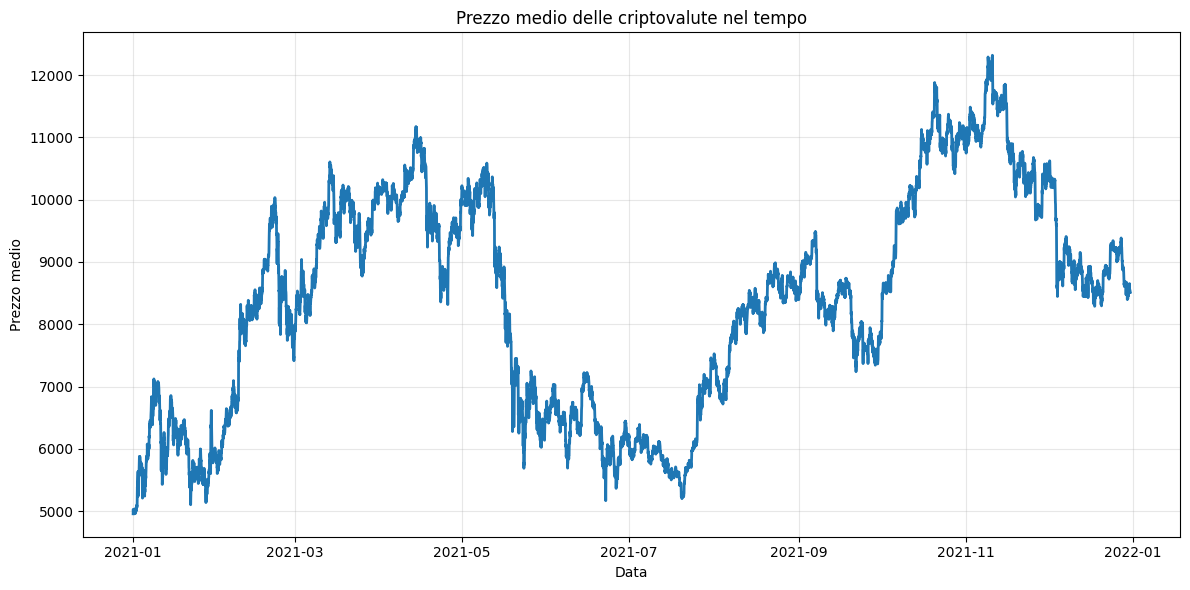

In [24]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices.mean(axis=1), label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [25]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [26]:
# Parametri fissi
initial_liquidity = 100

# Parametri variabili
timeframe = 24*30
timeframe_grid_search = 168 # un valore di -1 significa che diventa uguale a timeframe nella strategia; qui potrei anche mettere direttamente timeframe_grid_search=timeframe, ma in generale nella macro grid search che farò successivamente devo fare così
mobile_window = 24*14
weighting_factor = 1
coef_liquidity_out = 5
coef_liquidity_in = 1
dynamical_variables = {
    # 'coef_liquidity_in': [0, 1, np.inf],
    # 'coef_liquidity_out': [0, 1, np.inf],
    # 'func_monitor': [mstd_returns_prices, ma_returns_prices],
    # 'mobile_window': [48, 24*7],
    # 'timeframe': [24, 24*7, 24*14],
    # 'weighting_factor': [-1, 0, 1],
    # 'window_grid_search': [24*7, 24*14, 24*30]

} # VARIABILI DA NON METTERE IN dynamical_variables: dynamical_variables; timeframe_grid_search
window_grid_search = 24*15 # Consigliabile averlo maggiore di timeframe_grid_search (se "timeframe_grid_search" non compare in dynamical_variables), perchè altrimenti di fatto la grid search effettua delle mini-simulazioni in cui non ribilancia mai e il fattore di rendimento totale risulterà sempre uguale per tutte le combinazioni della grid search in questione
func_monitor = ma_returns_prices

df_results = simulate_trading_strategy(crypto_prices, initial_liquidity, initial_allocations, timeframe, timeframe_grid_search, mobile_window, weighting_factor, coef_liquidity_out, coef_liquidity_in, dynamical_variables, window_grid_search, func_monitor)
df_results

timestamp  liquidity  portfolio_value  avg_metric  \
0    2021-01-01 00:00:00   0.000000       100.000000         NaN   
1    2021-01-01 01:00:00   0.000000       101.342501         NaN   
2    2021-01-01 02:00:00   0.000000       101.477428         NaN   
3    2021-01-01 03:00:00   0.000000       102.659037         NaN   
4    2021-01-01 04:00:00   0.000000       102.115284         NaN   
...                  ...        ...              ...         ...   
8719 2021-12-30 20:00:00  72.155795     15847.200770   -0.000055   
8720 2021-12-30 21:00:00  72.155795     15942.470292   -0.000054   
8721 2021-12-30 22:00:00  72.155795     15839.261643   -0.000052   
8722 2021-12-30 23:00:00  72.155795     15894.835531   -0.000010   
8723 2021-12-31 00:00:00  72.155795     15831.322516   -0.000042   

      sub_metric_up  sub_return_up  MA_sub_return_up  price_BTC   qty_BTC  \
0               NaN            NaN               NaN   28995.13  0.000575   
1               NaN            NaN               NaN   29409.99  0.000575   
2               NaN            NaN               NaN   29194.65  0.000575   
3               NaN            NaN               NaN   29278.40  0.000575   
4               NaN            NaN               NaN   29220.31  0.000575   
...             ...            ...               ...        ...       ...   
8719      -0.000067       1.344441         -0.101133   47203.16  0.000000   
8720      -0.000018      -0.724704         -0.104474   47300.00  0.000000   
8721      -0.000052       1.797278         -0.098056   47084.88  0.000000   
8722            NaN       0.000000         -0.098719   47120.87  0.000000   
8723            NaN       0.000000         -0.098281   47073.98  0.000000   

      value_BTC  metric_BTC last_ext_type_BTC  last_ext_value_BTC  price_ETH  \
0     16.666667         NaN              None                 NaN     734.07   
1     16.905132         NaN              None                 NaN     748.28   
2     16.781353         NaN              None                 NaN     744.06   
3     16.829493         NaN              None                 NaN     744.82   
4     16.796102         NaN              None                 NaN     742.29   
...         ...         ...               ...                 ...        ...   
8719   0.000000   -0.000030               max            0.000008    3724.78   
8720   0.000000   -0.000034               min           -0.000034    3736.93   
8721   0.000000   -0.000030               min           -0.000034    3703.83   
8722   0.000000   -0.000016               max           -0.000016    3709.27   
8723   0.000000   -0.000029               max           -0.000016    3700.60   

       qty_ETH  value_ETH  metric_ETH last_ext_type_ETH  last_ext_value_ETH  \
0     0.022704  16.666667         NaN              None                 NaN   
1     0.022704  16.989297         NaN              None                 NaN   
2     0.022704  16.893484         NaN              None                 NaN   
3     0.022704  16.910740         NaN              None                 NaN   
4     0.022704  16.853297         NaN              None                 NaN   
...        ...        ...         ...               ...                 ...   
8719  0.000000   0.000000   -0.000205               min           -0.000205   
8720  0.000000   0.000000   -0.000204               max           -0.000204   
8721  0.000000   0.000000   -0.000214               min           -0.000214   
8722  0.000000   0.000000   -0.000173               max           -0.000173   
8723  0.000000   0.000000   -0.000195               max           -0.000173   

      price_SOL    qty_SOL  value_SOL  metric_SOL last_ext_type_SOL  \
0        1.5442  10.793075  16.666667         NaN              None   
1        1.5734  10.793075  16.981824         NaN              None   
2        1.5872  10.793075  17.130769         NaN              None   
3        1.6029  10.793075  17.300220         NaN              None   
4       

In [27]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

158.31322516455643

In [28]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

393.57647536225437

In [29]:
df_results['portfolio_value'].max(), df_results['portfolio_value'].iloc[-1]

(39357.64753622543, 15831.322516455639)

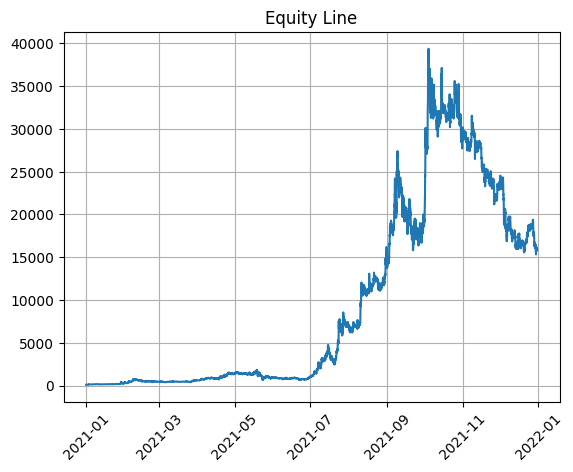

In [30]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [31]:
mdp.calcola_principali_metriche(portfolio_values=df_results['portfolio_value'])

{'Total Return %': 15731.322516455642,
 'Max Drawdown %': 65.18107364148737,
 'Volatility': 0.3347172378040391,
 'Sharpe Ratio': 0.6016684151037944,
 'Sortino Ratio': 1.0837355040936725,
 'Calmar Ratio': 241.3480115866448,
 'Profit Factor': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti',
 'PnL': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti'}

In [32]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys() if crypto != 'liquidity'], initial_liquidity, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[4.283913220607839e+59, 9.620487367455475e+61]

# Grid search

In [33]:
# Parametri fissi
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_liquidity = 100
sort_quantity = 'fattore_rendimento_totale'

In [ ]:
# Dizionario dei parametri per la grid search
param_grid = {
    'coef_liquidity_in': [1],
    'coef_liquidity_out': [1],
    'dynamical_variables': [{'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf], 'weighting_factor': [-1, 0, 1]}], # {'func_monitor': [ma_returns_prices, mstd_returns_prices]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf], 'weighting_factor': [-1, 0, 1]}
    'func_monitor': [ma_returns_prices],
    'mobile_window': [24*2],
    'timeframe': [24],
    'timeframe_grid_search': [-1, 24*7], # un valore di -1 significa che diventa uguale a timeframe nella strategia
    'weighting_factor': [0],
    'window_grid_search': [24*15, 24*30]
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = [] # Qua salvo le condizioni per cui è inutile fare il calcolo perchè il risultato sarebbe uguale a un'altra combinazione già vista

for comb in grid_params:
    condition = len(comb['dynamical_variables']) == 0 and comb['window_grid_search'] != param_grid['window_grid_search'][0] or len(comb['dynamical_variables']) == 0 and comb['timeframe_grid_search'] != param_grid['timeframe_grid_search'][0] or any([param in comb['dynamical_variables'].keys() and comb[param] != param_grid[param][0] for param in param_grid.keys()]) # riguardo alla condizione con "any": se una variabile cambia dinamicamente, salto tutte le combinazioni in cui la stessa variabile in versione statica assume valori diversi dal primo, perchè tanto cambia dinamicamente quel parametro (in realtà non è del tutto uguale perchè all'inizio conta il valore iniziale del parametro, è solo dalla prima mini grid search che cambia in modo dinamico, ma considero trascurabile l'effetto)
    skip_conditions.append(condition)

# crypto_list = crypto_prices.columns

# Esegue la grid search e visualizza i nuovi risultati
risultati_df_ordinati = grid_search_rebalancing(crypto_prices, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity)
risultati_df_ordinati['func_monitor'] = risultati_df_ordinati['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else x
        )


Inizio iterazione 1/4
Parametri: {'coef_liquidity_in': '1', 'coef_liquidity_out': '1', 'dynamical_variables': "{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'weighting_factor': [-1, 0, 1]}", 'func_monitor': 'ma_returns_prices', 'mobile_window': '48', 'timeframe': '24', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '360'}
Valore attuale del portafoglio totale: 108.38829571342654
temp_initial_allocations: {'liquidity': 0.0, 'BTC': 0.16666666666666669, 'ETH': 0.16666666666666669, 'SOL': 0.16666666666666669, 'DOGE': 0.16666666666666669, 'LINK': 0.16666666666666669, 'AXS': 0.16666666666666669}
Sto per fare la grid search del giorno 2021-01-02 00:00:00 (i=24)...

Inizio iterazione 1/27
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '48', 'timeframe': '24', 'timeframe_grid_search': '24', 'weighting_factor': '-1', 'window_grid_search': '3

In [36]:
print('risultati_df_ordinati:')
risultati_df_ordinati

risultati_df_ordinati:


coef_liquidity_in  coef_liquidity_out  \
0                   1                   1   
1                   1                   1   
2                   1                   1   
3                   1                   1   
4                   1                   1   
5                   1                   1   
6                   1                   1   
7                   1                   1   
8                   1                   1   
9                   1                   1   
10                  1                   1   
11                  1                   1   

                                  dynamical_variables       func_monitor  \
0   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
1   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
2   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
3   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
4   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
5   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
6   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
7   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
8   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
9   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
10  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
11  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   

    mobile_window  timeframe  timeframe_grid_search  weighting_factor  \
0              48        336                     -1                 0   
1              48        336                    168                 0   
2              48        336                     -1                 0   
3              48        168                     -1                 0   
4              48        168                    168                 0   
5              48        168                     -1                 0   
6              48        168                    168                 0   
7              48        336                    168                 0   
8              48        720                    168                 0   
9              48        720                     -1                 0   
10             48        720                     -1                 0   
11             48        720                    168                 0   

    window_grid_search  fattore_rendimento_totale  volatility  max_drawdown  \
0                  720                 446.307758    0.358927     78.402161   
1                  360                 204.249150    0.281040     78.319273   
2                  360                 155.759400    0.293912     73.391574   
3                  360                 154.124079    0.303564     64.988912   
4                  360                 154.124079    0.303564     64.988912   
5                  720                  27.535769    0.343661     68.194708   
6                  720                  27.535769    0.343661     68.194708   
7                  720                   5.865299    0.313085     76.122530   
8                  720                   4.829831    0.209913     45.542924   
9                  360                   3.213941    0.301898     73.462365   
10                 720                   3.213941    0.301898     73.462365   
11                 360                   2.901033    0.258754     73.462365   

    sharpe_ratio  sortino_ratio  calmar_ratio  
0       0.663803       1.169107    567.978933  
1       0.685777       1.175279    259.513581  
2       0.641781       1.102054    210.868077  
3       0.627050       1.125188    235.615699  
4       0.627050       1.125188    235.615699  
5       0.444015       0.756806     38.911771  
6       0.444015       0.756806     38.911771  
7       0.312321       0.539435      6.391404  
8       0.314445   

In [37]:
# Converti eventuali colonne di tipo dict in stringa
for col in risultati_df_ordinati.columns:
    if risultati_df_ordinati[col].apply(lambda x: isinstance(x, dict)).any():
        risultati_df_ordinati[col] = risultati_df_ordinati[col].apply(lambda x: str(x))

# Carica i vecchi risultati dal file CSV
try:
    old_results = pd.read_csv('Risultati Rotazione multi-asset con medie mobili.csv')
except FileNotFoundError:
    old_results = pd.DataFrame()  # Crea un DataFrame vuoto se il file non esiste

# Concatena i vecchi e nuovi risultati, rimuovendo duplicati e reindicizzando
total_results = pd.concat([old_results, risultati_df_ordinati]).drop_duplicates().reset_index(drop=True)
total_results = total_results.sort_values(by='fattore_rendimento_totale', ascending=False)
print('total_results:')
display(total_results)

# Salva i risultati aggiornati nel file CSV senza l'indice
total_results.to_csv('Risultati Rotazione multi-asset con medie mobili.csv', index=False)

total_results:


coef_liquidity_in  coef_liquidity_out  \
0                     1                   1   
1                     5                   1   
2                     1                   1   
3                     5                   1   
4                     1                   1   
...                 ...                 ...   
1479                  5                   5   
1480                  5                   5   
1481                  5                   1   
1482                  5                   5   
1483                  5                   1   

                                    dynamical_variables  \
0     {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
1                      {'weighting_factor': [-1, 0, 1]}   
2                      {'weighting_factor': [-1, 0, 1]}   
3                      {'weighting_factor': [-1, 0, 1]}   
4                      {'weighting_factor': [-1, 0, 1]}   
...                                                 ...   
1479                  {'weighting_factor': [0, 0.5, 1]}   
1480                  {'weighting_factor': [0, 0.5, 1]}   
1481                  {'weighting_factor': [0, 0.5, 1]}   
1482                                                 {}   
1483                                                 {}   

                func_monitor  mobile_window  timeframe  timeframe_grid_search  \
0          ma_returns_prices             48        336                     24   
1          ma_returns_prices            336        336                    168   
2          ma_returns_prices            336        336                    168   
3          ma_returns_prices            336        336                     24   
4          ma_returns_prices            336        336                     24   
...                      ...            ...        ...                    ...   
1479  ma_mstd_returns_prices             48        336                     -1   
1480  ma_mstd_returns_prices             48        168                     -1   
1481  ma_mstd_returns_prices             48        168                     -1   
1482  ma_mstd_returns_prices             48        168                     -1   
1483  ma_mstd_returns_prices             48        168                     -1   

      weighting_factor  window_grid_search  fattore_rendimento_totale  \
0                    0                 720                 908.494398   
1                    0                 360                 752.989043   
2                    0                 360                 732.949699   
3                    0                 360                 683.167978   
4                    0                 360                 664.966256   
...                ...                 ...                        ...   
1479                 0                 360                   1.006958   
1480                 0                 720                   0.622838   
1481                 0                 720                   0.610672   
1482                 1                 360                   0.545413   
1483                 1                 360                   0.497671   

      volatility  max_drawdown  sharpe_ratio  sortino_ratio  calmar_ratio  
0       0.338154     68.194708      0.744260       1.338903   1330.740203  
1       0.305012     63.960810      0.777325       1.349248   1175.702811  
2       0.304468     63.960810      0.775615       1.344309   1144.372152  
3       0.303894     63.960810      0.769824       1.334817   1066.540554  
4       0.303348     63.960810      0.768096       1.329865   1038.082937  
...          ...           ...           ...            ...           ...  
1479    0.157697     65.762144      0.079378       0.121880      0.010580  
1480    0.201404     83.896958      0.032621       0.048315     -0.449554  
1481    0.203551     84.952063      0.031871       0.046876     -0.458292  
1482    0.288911     87.269260      0.075642       0.124756     -0.520901  
1483    0.297587     88.383640      0.073287  

In [39]:
# Assicuriamoci che tutte le colonne di parametri siano rappresentate come stringhe
df_params = total_results[list(param_grid.keys())].astype(str)

# Contiamo quante volte compare ogni combinazione unica di parametri
param_counts = df_params.value_counts()

# Se ci sono duplicati (cioè combinazioni che appaiono più volte), qualcosa non va
if (param_counts > 1).any():
    print("ATTENZIONE: Esistono combinazioni di parametri duplicate con risultati diversi!")
else:
    print("Tutto OK: ogni combinazione di parametri è unica.")

# Se vuoi vedere le combinazioni duplicate
duplicates = param_counts[param_counts > 1]
if not duplicates.empty:
    print("Combinazioni duplicate trovate:\n", duplicates)

Tutto OK: ogni combinazione di parametri è unica.


In [40]:
# Verifico che non ci siano combinazioni di parametri uguali con risultati diversi (altrimenti ci sarebbe qualcosa di sbagliato): il value_counts sui soli parametri deve darmi tutti 1
total_results[param_grid.keys()].value_counts()

coef_liquidity_in  coef_liquidity_out  dynamical_variables                                                                                    func_monitor         mobile_window  timeframe  timeframe_grid_search  weighting_factor  window_grid_search
1                  1                   {'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'weighting_factor': [-1, 0, 1]}  ma_returns_prices    48             168        -1                     0                 360                   1
5                  1                   {'weighting_factor': [-1, 0, 1]}                                                                       mstd_returns_prices  168            168         24                    0                 360                   1
                                                                                                                                                                                  336         168                   0                 720          

In [ ]:
total_results[(total_results['weighting_factor'] == 0) & (total_results['func_monitor'] == 'ma_returns_prices') & (total_results['coef_liquidity_in'] == 1) & (total_results['coef_liquidity_out'] == 1) & (total_results['dynamical_variables'] == "{'weighting_factor': [-1, 0, 1]}") & (total_results['mobile_window'] == 336)].sort_values(by='fattore_rendimento_totale', ascending=False)

coef_liquidity_in  coef_liquidity_out               dynamical_variables  \
2                    1                   1  {'weighting_factor': [-1, 0, 1]}   
4                    1                   1  {'weighting_factor': [-1, 0, 1]}   
22                   1                   1  {'weighting_factor': [-1, 0, 1]}   
30                   1                   1  {'weighting_factor': [-1, 0, 1]}   
52                   1                   1  {'weighting_factor': [-1, 0, 1]}   
58                   1                   1  {'weighting_factor': [-1, 0, 1]}   
144                  1                   1  {'weighting_factor': [-1, 0, 1]}   
247                  1                   1  {'weighting_factor': [-1, 0, 1]}   
403                  1                   1  {'weighting_factor': [-1, 0, 1]}   
423                  1                   1  {'weighting_factor': [-1, 0, 1]}   
424                  1                   1  {'weighting_factor': [-1, 0, 1]}   
445                  1                   1  {'weighting_factor': [-1, 0, 1]}   
444                  1                   1  {'weighting_factor': [-1, 0, 1]}   
460                  1                   1  {'weighting_factor': [-1, 0, 1]}   
598                  1                   1  {'weighting_factor': [-1, 0, 1]}   
624                  1                   1  {'weighting_factor': [-1, 0, 1]}   
700                  1                   1  {'weighting_factor': [-1, 0, 1]}   
699                  1                   1  {'weighting_factor': [-1, 0, 1]}   

          func_monitor  mobile_window  timeframe  timeframe_grid_search  \
2    ma_returns_prices            336        336                    168   
4    ma_returns_prices            336        336                     24   
22   ma_returns_prices            336        720                     24   
30   ma_returns_prices            336        720                    168   
52   ma_returns_prices            336        720                     24   
58   ma_returns_prices            336        336                     24   
144  ma_returns_prices            336        336                    168   
247  ma_returns_prices            336        168                     24   
403  ma_returns_prices            336        720                    168   
423  ma_returns_prices            336        168                     -1   
424  ma_returns_prices            336        168                    168   
445  ma_returns_prices            336        720                     -1   
444  ma_returns_prices            336        720                     -1   
460  ma_returns_prices            336        336                     -1   
598  ma_returns_prices            336        168                     24   
624  ma_returns_prices            336        336                     -1   
700  ma_returns_prices            336        168                    168   
699  ma_returns_prices            336        168                     -1   

     weighting_factor  window_grid_search  fattore_rendimento_totale  \
2                   0                 360                 732.949699   
4                   0                 360                 664.966256   
22                  0                 720                 503.448880   
30                  0                 720                 483.817051   
52                  0                 360                 415.149263   
58                  0                 720                 347.125938   
144                 0                 720                 190.611766   
247                 0                 360                 115.467279   
403                 0                 360                  73.871947   
423                 0                 360                  70.465453   
424                 0                 360                  70.465453   
445                 0                 720                  66.969039   
444                 0                 360                  66.969039   
460                 0                 720         

In [42]:
df_over_100 = total_results[total_results['fattore_rendimento_totale'] > 100]
df_over_100

coef_liquidity_in  coef_liquidity_out  \
0                    1                   1   
1                    5                   1   
2                    1                   1   
3                    5                   1   
4                    1                   1   
..                 ...                 ...   
284                  1                   1   
285                  1                   1   
286                  5                   5   
287                  5                   1   
288                  1                   1   

                                   dynamical_variables         func_monitor  \
0    {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...    ma_returns_prices   
1                     {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
2                     {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
3                     {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
4                     {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
..                                                 ...                  ...   
284  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  mstd_returns_prices   
285                   {'weighting_factor': [-1, 0, 1]}  mstd_returns_prices   
286                   {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
287                   {'weighting_factor': [-1, 0, 1]}    ma_returns_prices   
288                   {'weighting_factor': [-1, 0, 1]}  mstd_returns_prices   

     mobile_window  timeframe  timeframe_grid_search  weighting_factor  \
0               48        336                     24                 0   
1              336        336                    168                 0   
2              336        336                    168                 0   
3              336        336                     24                 0   
4              336        336                     24                 0   
..             ...        ...                    ...               ...   
284            336        168                     -1                 1   
285             48        168                     24                 0   
286            336        720                    168                 0   
287            336        720                    168                 0   
288             48        336                    168                 0   

     window_grid_search  fattore_rendimento_totale  volatility  max_drawdown  \
0                   720                 908.494398    0.338154     68.194708   
1                   360                 752.989043    0.305012     63.960810   
2                   360                 732.949699    0.304468     63.960810   
3                   360                 683.167978    0.303894     63.960810   
4                   360                 664.966256    0.303348     63.960810   
..                  ...                        ...         ...           ...   
284                 360                 101.194671    0.411480     70.248045   
285                 720                 101.176313    0.308428     78.805773   
286                 720                 101.064860    0.283420     62.587929   
287                 720                 101.003863    0.283453     62.587929   
288                 720                 100.152764    0.315962     65.428824   

     sharpe_ratio  sortino_ratio  calmar_ratio  
0        0.744260       1.338903   1330.740203  
1        0.777325       1.349248   1175.702811  
2        0.775615       1.344309   1144.372152  
3        0.769824       1.334817   1066.540554  
4        0.768096       1.329865   1038.082937  
..            ...            ...           ...  
284      0.520383       0.965629    142.629835  
285      0.585379       1.011442    127.117987  
286      0.610217       1.047672    159.878849  
287      0.610117       1.047479    159.781391  
288      0.574721       1.047445    151.542942  

[294 rows x 15 columns]

In [43]:
df_over_100[['dynamical_variables', 'func_monitor']].value_counts()

coef_liquidity_in
1    236
5     58
Name: count, dtype: int64

In [44]:
mean_values = df_over_100.select_dtypes(include=['number']).mean()
mean_values

coef_liquidity_in              1.789116
coef_liquidity_out             2.006803
mobile_window                182.612245
timeframe                    424.163265
timeframe_grid_search         53.918367
weighting_factor               0.295918
window_grid_search           494.693878
fattore_rendimento_totale    247.016861
volatility                     0.325441
max_drawdown                  67.005229
sharpe_ratio                   0.639206
sortino_ratio                  1.143655
calmar_ratio                 365.823835
dtype: float64

In [45]:
median_values = df_over_100.select_dtypes(include=['number']).median()
median_values

coef_liquidity_in              1.000000
coef_liquidity_out             1.000000
mobile_window                168.000000
timeframe                    336.000000
timeframe_grid_search         24.000000
weighting_factor               0.000000
window_grid_search           360.000000
fattore_rendimento_totale    188.433320
volatility                     0.321950
max_drawdown                  68.194708
sharpe_ratio                   0.639895
sortino_ratio                  1.137604
calmar_ratio                 285.864381
dtype: float64

In [ ]:
# Cerco il sottoinsieme di dati di df_over_100 per cui è massimizzato il rapporto tra il numero di dati considerati e la deviazione standard del fattore_rendimento_totale, così da farmi un'idea di quali sono i parametri che tendono a dare risultati alti e in un intorno ristretto di valori

def find_optimal_subset(df, target_col):
    """
    Trova il sottoinsieme di dati che massimizza il rapporto tra
    il numero di dati presenti e la deviazione standard dei valori
    della colonna target_col.
    """
    # Ordina il DataFrame in base ai valori della colonna target
    df_sorted = df.sort_values(by=target_col)
    
    best_ratio = -np.inf
    best_subset = None
    best_threshold = None
    
    # Itera su possibili soglie
    for threshold in df_sorted[target_col].unique():
        subset = df_sorted[df_sorted[target_col] >= threshold]
        subset_size = len(subset)
        
        if subset_size > 1:  # Evita divisioni per zero o calcoli su un singolo elemento
            std_dev = subset[target_col].std()
            if std_dev > 0:
                ratio = subset_size / std_dev
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_subset = subset
                    best_threshold = threshold
    
    return best_subset, best_threshold, best_ratio

# Utilizzo della funzione
optimal_subset, optimal_threshold, optimal_ratio = find_optimal_subset(df_over_100, 'fattore_rendimento_totale')

print(f"Soglia ottimale: {optimal_threshold}")
print(f"Rapporto ottimale (dimensione/DS): {optimal_ratio}")
print(f"Dimensione del sottoinsieme ottimale: {len(optimal_subset)}")
optimal_subset

In [46]:
total_results[:50]

coef_liquidity_in  coef_liquidity_out  \
0                   1                   1   
1                   5                   1   
2                   1                   1   
3                   5                   1   
4                   1                   1   
6                   1                   1   
5                   1                   1   
7                   1                   1   
8                   1                   1   
9                   1                   1   
10                  1                   1   
11                  5                   1   
15                  1                   1   
17                  1                   1   
16                  1                   1   
18                  1                   1   
14                  1                   1   
12                  1                   1   
13                  1                   1   
19                  1                   1   
20                  5                   5   
21                  1                   5   
22                  1                   1   
23                  1                   1   
24                  1                   1   
26                  1                   1   
27                  1                   1   
25                  1                   1   
28                  5                   1   
29                  1                   5   
30                  1                   1   
35                  1                   1   
37                  1                   1   
36                  1                   1   
33                  1                   1   
34                  1                   1   
32                  1                   1   
31                  1                   1   
38                  1                   1   
39                  1                   1   
40                  1                   1   
41                  1                   1   
42                  1                   1   
43                  1                   1   
44                  1                   1   
45                  1                   1   
46                  1                   1   
47                  1                   1   
48                  1                   1   
49                  1                   1   

                                  dynamical_variables       func_monitor  \
0   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
1                    {'weighting_factor': [-1, 0, 1]}  ma_returns_prices   
2                    {'weighting_factor': [-1, 0, 1]}  ma_returns_prices   
3                    {'weighting_factor': [-1, 0, 1]}  ma_returns_prices   
4                    {'weighting_factor': [-1, 0, 1]}  ma_returns_prices   
6   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
5   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
7   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
8   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
9   {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
10  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...  ma_returns_prices   
11                                                 {}  ma_returns_prices   
15  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
17                                                 {}  ma_returns_prices   
16  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
18  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
14  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
12  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
13  {'func_monitor': [<function ma_returns_prices ...  ma_returns_prices   
19                  {'weighting_factor': [0, 0.5, 1]}  ma_returns_prices   
20                                                 {}  ma_returns_prices   
21                   {'weighting_fac

In [47]:
total_results[-50:]

coef_liquidity_in  coef_liquidity_out  \
1435                  1                   5   
1434                  1                   1   
1436                  5                   1   
1437                  5                   5   
1438                  5                   1   
1439                  5                   5   
1440                  5                   5   
1441                  1                   5   
1442                  1                   5   
1443                  1                   1   
1444                  5                   1   
1445                  5                   5   
1446                  1                   5   
1447                  1                   5   
1448                  5                   5   
1449                  5                   5   
1450                  5                   5   
1451                  5                   1   
1452                  1                   5   
1453                  1                   5   
1454                  5                   5   
1455                  1                   5   
1456                  5                   5   
1457                  5                   5   
1458                  1                   5   
1459                  5                   5   
1460                  1                   5   
1461                  5                   5   
1462                  5                   5   
1463                  5                   5   
1464                  1                   5   
1465                  5                   5   
1466                  1                   5   
1467                  5                   5   
1468                  1                   5   
1469                  5                   5   
1470                  1                   5   
1471                  5                   5   
1472                  1                   5   
1473                  1                   1   
1474                  1                   5   
1475                  1                   5   
1476                  1                   1   
1477                  5                   1   
1478                  5                   5   
1479                  5                   5   
1480                  5                   5   
1481                  5                   1   
1482                  5                   5   
1483                  5                   1   

                    dynamical_variables            func_monitor  \
1435  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1434  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1436  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1437  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1438  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1439  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1440  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1441  {'weighting_factor': [0, 0.5, 1]}  ma_mstd_returns_prices   
1442                                 {}          mstd_ma_prices   
1443                                 {}          mstd_ma_prices   
1444                                 {}          mstd_ma_prices   
1445                                 {}          mstd_ma_prices   
1446  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1447                                 {}          mstd_ma_prices   
1448                                 {}          mstd_ma_prices   
1449  {'weighting_factor': [0, 0.5, 1]}          mstd_ma_prices   
1450                                 {}          ma_mstd_prices   
1451                                 {}          ma_mstd_prices   
1452  {'weighting_factor': [0, 0.5, 1]}        mstd_mstd_prices   
1453  {'weighting_factor': [0, 0.5, 1]}        mstd_mstd_prices   
1454  {'weighting_factor': [0, 0.5, 1]}        mstd_mstd_prices   
1455                                 {}        mstd_mstd_prices   
1456  {'weighting_factor': [0, 0.5, 1]}        mstd_mstd_prices   


In [48]:
total_results['fattore_rendimento_totale'].mean(), total_results['fattore_rendimento_totale'].median(), total_results['fattore_rendimento_totale'].min(), total_results['fattore_rendimento_totale'].max(), total_results['fattore_rendimento_totale'].std()

(70.90065058989256,
 30.13516542595235,
 0.4976708403502816,
 908.4943979832716,
 112.29803986437227)

In [49]:
total_results.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

coef_liquidity_in  coef_liquidity_out  \
0                     5                   1   
1                     1                   1   
2                     5                   1   
3                     1                   1   
4                     5                   1   
...                 ...                 ...   
1491                  5                   5   
1492                  5                   5   
1493                  5                   1   
1494                  5                   5   
1495                  5                   1   

                    dynamical_variables            func_monitor  \
0      {'weighting_factor': [-1, 0, 1]}       ma_returns_prices   
1      {'weighting_factor': [-1, 0, 1]}       ma_returns_prices   
2      {'weighting_factor': [-1, 0, 1]}       ma_returns_prices   
3      {'weighting_factor': [-1, 0, 1]}       ma_returns_prices   
4                                    {}       ma_returns_prices   
...                                 ...                     ...   
1491  {'weighting_factor': [0, 0.5, 1]}  ma_mstd_returns_prices   
1492                                 {}  ma_mstd_returns_prices   
1493                                 {}  ma_mstd_returns_prices   
1494  {'weighting_factor': [0, 0.5, 1]}  ma_mstd_returns_prices   
1495  {'weighting_factor': [0, 0.5, 1]}  ma_mstd_returns_prices   

      mobile_window  timeframe  timeframe_grid_search  weighting_factor  \
0               336        336                    168                 0   
1               336        336                    168                 0   
2               336        336                     24                 0   
3               336        336                     24                 0   
4               336        336                     -1                 0   
...             ...        ...                    ...               ...   
1491             48        336                     -1                 0   
1492             48        168                     -1                 1   
1493             48        168                     -1                 1   
1494             48        168                     -1                 0   
1495             48        168                     -1                 0   

      window_grid_search  fattore_rendimento_totale  volatility  max_drawdown  \
0                    360                 752.989043    0.305012     63.960810   
1                    360                 732.949699    0.304468     63.960810   
2                    360                 683.167978    0.303894     63.960810   
3                    360                 664.966256    0.303348     63.960810   
4                    360                 547.354778    0.305107     73.203132   
...                  ...                        ...         ...           ...   
1491                 360                   1.006958    0.157697     65.762144   
1492                 360                   0.545413    0.288911     87.269260   
1493                 360                   0.497671    0.297587     88.383640   
1494                 720                   0.622838    0.201404     83.896958   
1495                 720                   0.610672    0.203551     84.952063   

      sharpe_ratio  sortino_ratio  calmar_ratio  
0         0.777325       1.349248   1175.702811  
1         0.775615       1.344309   1144.372152  
2         0.769824       1.334817   1066.540554  
3         0.768096       1.329865   1038.082937  
4         0.747012       1.288239    746.354373  
...            ...            ...           ...  
1491      0.079378       0.121880      0.010580  
1492      0.075642       0.124756     -0.520901  
1493      0.073287       0.119883     -0.568351  
1494      0.032621       0.048315     -0.449554  
1495      0.031871       0.046876     -0.458292  

[1496 rows x 15 columns]

In [50]:
total_results.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

coef_liquidity_in  coef_liquidity_out  \
0                     5                   1   
1                     1                   1   
2                     1                   1   
3                     1                   1   
4                     5                   1   
...                 ...                 ...   
1491                  5                   5   
1492                  5                   5   
1493                  5                   1   
1494                  5                   5   
1495                  5                   1   

                                    dynamical_variables  \
0                      {'weighting_factor': [-1, 0, 1]}   
1     {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
2                      {'weighting_factor': [-1, 0, 1]}   
3     {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
4                      {'weighting_factor': [-1, 0, 1]}   
...                                                 ...   
1491                                                 {}   
1492                  {'weighting_factor': [0, 0.5, 1]}   
1493                                                 {}   
1494                  {'weighting_factor': [0, 0.5, 1]}   
1495                  {'weighting_factor': [0, 0.5, 1]}   

                func_monitor  mobile_window  timeframe  timeframe_grid_search  \
0          ma_returns_prices            336        336                    168   
1          ma_returns_prices            168        720                    168   
2          ma_returns_prices            336        336                    168   
3          ma_returns_prices             48        336                     24   
4          ma_returns_prices            336        336                     24   
...                      ...            ...        ...                    ...   
1491  ma_mstd_returns_prices             48        168                     -1   
1492  ma_mstd_returns_prices             48        336                     -1   
1493  ma_mstd_returns_prices             48        168                     -1   
1494  ma_mstd_returns_prices             48        168                     -1   
1495  ma_mstd_returns_prices             48        168                     -1   

      weighting_factor  window_grid_search  fattore_rendimento_totale  \
0                    0                 360                 752.989043   
1                    1                 720                 586.484604   
2                    0                 360                 732.949699   
3                    0                 720                 908.494398   
4                    0                 360                 683.167978   
...                ...                 ...                        ...   
1491                 1                 360                   0.545413   
1492                 0                 360                   1.006958   
1493                 1                 360                   0.497671   
1494                 0                 720                   0.622838   
1495                 0                 720                   0.610672   

      volatility  max_drawdown  sharpe_ratio  sortino_ratio  calmar_ratio  
0       0.305012     63.960810      0.777325       1.349248   1175.702811  
1       0.327276     50.369990      0.719440       1.346930   1162.367908  
2       0.304468     63.960810      0.775615       1.344309   1144.372152  
3       0.338154     68.194708      0.744260       1.338903   1330.740203  
4       0.303894     63.960810      0.769824       1.334817   1066.540554  
...          ...           ...           ...            ...           ...  
1491    0.288911     87.269260      0.075642       0.124756     -0.520901  
1492    0.157697     65.762144      0.079378       0.121880      0.010580  
1493    0.297587     88.383640      0.073287       0.119883     -0.568351  
1494    0.201404     83.896958      0.032621       0.048315     -0.449554  
1495    0.203551     84.952063      0.031871  

In [51]:
total_results.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

coef_liquidity_in  coef_liquidity_out  \
0                     1                   1   
1                     5                   1   
2                     1                   1   
3                     1                   1   
4                     5                   1   
...                 ...                 ...   
1491                  5                   5   
1492                  5                   5   
1493                  5                   1   
1494                  5                   5   
1495                  5                   1   

                                    dynamical_variables  \
0     {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
1                      {'weighting_factor': [-1, 0, 1]}   
2     {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
3                      {'weighting_factor': [-1, 0, 1]}   
4                      {'weighting_factor': [-1, 0, 1]}   
...                                                 ...   
1491                  {'weighting_factor': [0, 0.5, 1]}   
1492                  {'weighting_factor': [0, 0.5, 1]}   
1493                  {'weighting_factor': [0, 0.5, 1]}   
1494                                                 {}   
1495                                                 {}   

                func_monitor  mobile_window  timeframe  timeframe_grid_search  \
0          ma_returns_prices             48        336                     24   
1          ma_returns_prices            336        336                    168   
2          ma_returns_prices            168        720                    168   
3          ma_returns_prices            336        336                    168   
4          ma_returns_prices            336        336                     24   
...                      ...            ...        ...                    ...   
1491  ma_mstd_returns_prices             48        336                     -1   
1492  ma_mstd_returns_prices             48        168                     -1   
1493  ma_mstd_returns_prices             48        168                     -1   
1494  ma_mstd_returns_prices             48        168                     -1   
1495  ma_mstd_returns_prices             48        168                     -1   

      weighting_factor  window_grid_search  fattore_rendimento_totale  \
0                    0                 720                 908.494398   
1                    0                 360                 752.989043   
2                    1                 720                 586.484604   
3                    0                 360                 732.949699   
4                    0                 360                 683.167978   
...                ...                 ...                        ...   
1491                 0                 360                   1.006958   
1492                 0                 720                   0.622838   
1493                 0                 720                   0.610672   
1494                 1                 360                   0.545413   
1495                 1                 360                   0.497671   

      volatility  max_drawdown  sharpe_ratio  sortino_ratio  calmar_ratio  
0       0.338154     68.194708      0.744260       1.338903   1330.740203  
1       0.305012     63.960810      0.777325       1.349248   1175.702811  
2       0.327276     50.369990      0.719440       1.346930   1162.367908  
3       0.304468     63.960810      0.775615       1.344309   1144.372152  
4       0.303894     63.960810      0.769824       1.334817   1066.540554  
...          ...           ...           ...            ...           ...  
1491    0.157697     65.762144      0.079378       0.121880      0.010580  
1492    0.201404     83.896958      0.032621       0.048315     -0.449554  
1493    0.203551     84.952063      0.031871       0.046876     -0.458292  
1494    0.288911     87.269260      0.075642       0.124756     -0.520901  
1495    0.297587     88.383640      0.073287  

In [52]:
total_results.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

coef_liquidity_in  coef_liquidity_out  \
0                     1                   5   
1                     1                   5   
2                     1                   5   
3                     5                   1   
4                     5                   1   
...                 ...                 ...   
1491                  1                   1   
1492                  1                   1   
1493                  5                   1   
1494                  5                   5   
1495                  5                   1   

                                    dynamical_variables  \
0                     {'weighting_factor': [0, 0.5, 1]}   
1                     {'weighting_factor': [0, 0.5, 1]}   
2                                                    {}   
3                     {'weighting_factor': [0, 0.5, 1]}   
4                     {'weighting_factor': [0, 0.5, 1]}   
...                                                 ...   
1491  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
1492  {'coef_liquidity_in': [0, 1, inf], 'coef_liqui...   
1493                  {'weighting_factor': [0, 0.5, 1]}   
1494                                                 {}   
1495                                                 {}   

                func_monitor  mobile_window  timeframe  timeframe_grid_search  \
0     ma_mstd_returns_prices            168        168                     -1   
1     ma_mstd_returns_prices            168        168                     -1   
2     ma_mstd_returns_prices            168        168                     -1   
3                  ma_prices             48        168                     -1   
4                  ma_prices             48        168                     -1   
...                      ...            ...        ...                    ...   
1491     mstd_returns_prices             48        168                     -1   
1492     mstd_returns_prices             48        168                    168   
1493  ma_mstd_returns_prices             48        168                     -1   
1494  ma_mstd_returns_prices             48        168                     -1   
1495  ma_mstd_returns_prices             48        168                     -1   

      weighting_factor  window_grid_search  fattore_rendimento_totale  \
0                    0                 720                   5.878344   
1                    0                 360                   7.450231   
2                    0                 360                   7.892886   
3                    0                 360                   1.625741   
4                    0                 720                   1.628655   
...                ...                 ...                        ...   
1491                 1                 360                  19.231400   
1492                 1                 360                  19.231400   
1493                 0                 720                   0.610672   
1494                 1                 360                   0.545413   
1495                 1                 360                   0.497671   

      volatility  max_drawdown  sharpe_ratio  sortino_ratio  calmar_ratio  
0       0.113787     28.430127      0.506348       0.815425     17.159067  
1       0.115469     28.430127      0.559962       0.899318     22.688013  
2       0.114026     28.430127      0.580270       0.925293     24.245008  
3       0.083958     28.626812      0.209293       0.303657      2.185856  
4       0.083920     28.626812      0.209963       0.304638      2.196035  
...          ...           ...           ...            ...           ...  
1491    0.397549     84.530960      0.406531       0.723277     21.567719  
1492    0.397549     84.530960      0.406531       0.723277     21.567719  
1493    0.203551     84.952063      0.031871       0.046876     -0.458292  
1494    0.288911     87.269260      0.075642       0.124756     -0.520901  
1495    0.297587     88.383640      0.073287  

# Machine learning per trovare relazioni tra parametri e target

## Random forest

In [53]:
def train_random_forest_regressor(
    risultati_df_ordinati,
    feature_cols,
    target_col,
    test_size=0.2,
    random_state=42,
    # Parametri generici della RandomForest (valori di default)
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    # Valore numerico limite per sostituire np.inf
    max_val=1e9
):
    """
    Allena una RandomForestRegressor per predire 'target_col' (continuo) 
    a partire da 'feature_cols'. Sostituisce eventuali valori np.inf / -np.inf con +/- max_val.
    Mostra le importanze delle feature (anche graficamente).

    Parametri
    ---------
    risultati_df_ordinati : pd.DataFrame
        Il DataFrame con i dati (colonne di parametri e colonna target).
    feature_cols : list
        Lista di nomi di colonne da usare come feature (parametri).
    target_col : str
        Nome della colonna target (es. 'fattore_rendimento_totale').
    test_size : float
        Percentuale di dati nel test set (default 0.2 = 20%).
    random_state : int
        Seed per la riproducibilità.
    n_estimators : int
        Numero di alberi nella foresta. Default=100.
    criterion : str
        Funzione di split ('squared_error', 'absolute_error', ecc.).
    max_depth : int
        Profondità massima degli alberi, None = illimitata.
    min_samples_split : int
        Min numero di campioni per dividere un nodo.
    min_samples_leaf : int
        Min numero di campioni in un leaf node.
    min_weight_fraction_leaf : float
        Min frazione peso sample in un leaf node.
    max_features : str/int/float
        Numero di feature da considerare a ogni split.
    max_leaf_nodes : int
        Numero massimo di leaf nodes.
    min_impurity_decrease : float
        Soglia per ridurre la crescita del nodo se non migliora l'impurity.
    bootstrap : bool
        Usa il bootstrap per il campionamento.
    oob_score : bool
        Se True, calcola lo score out-of-bag.
    n_jobs : int
        Numero di job in parallelo (None=1, -1=usa tutti i core).
    verbose : int
        Livello di verbosità.
    warm_start : bool
        Se True, riusa la soluzione dell'albero precedente per addestrare uno nuovo.
    ccp_alpha : float
        Parametro di complessità di potatura Minimal Cost-Complexity.
    max_samples : int/float
        Se bootstrap=True, numero o frazione di campioni da campionare a ogni albero.
    max_val : float
        Valore con cui sostituire np.inf e -np.inf.

    Ritorna
    -------
    model : RandomForestRegressor
        Il modello allenato.
    """
    # Sostituiamo np.inf e -np.inf con +/- max_val
    for col in feature_cols:
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([float('inf')], max_val)
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([-float('inf')], -max_val)

    # Selezioniamo le feature e il target
    X = risultati_df_ordinati[feature_cols]
    y = risultati_df_ordinati[target_col]

    # Suddivisione train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Inizializziamo il modello di Random Forest Regressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )

    # Fit del modello
    model.fit(X_train, y_train)

    # Predizione sul test set
    y_pred = model.predict(X_test)

    # Metriche di valutazione
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"R^2 (test):  {r2:.4f}")
    print(f"RMSE (test): {rmse:.4f}")

    # Feature importances
    importances = model.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())

    feats_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)

    print("\nFeature Importances (valore assoluto e percentuale):")
    display(feats_imp.sort_values('importance_pct', ascending=False))

    # Plot orizzontale delle importanze (percentuali)
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return model

In [54]:
def normalize_dynamical_vars_dict(d: dict) -> str:
    """
    Dato un dizionario `d` (es: {'func_monitor': [<function ma_returns_prices>, <function mstd_prices>],
                                'coef_liquidity_in': [0, inf]},
    costruisce una stringa canonica, in cui:
      - le chiavi sono in ordine alfabetico;
      - ogni valore (che e' *sempre* una lista) viene ordinato come stringhe;
      - i Callable vengono sostituiti col loro nome (.__name__),
      - i float speciali (inf) vengono convertiti in "inf",
      - e si genera uno spacing coerente.

    Esempio:
      {'func_monitor': [mstd_prices, ma_returns_prices], 'coef_liquidity_in': [1, inf]}
      => "{'coef_liquidity_in': [1, inf], 'func_monitor': [ma_returns_prices, mstd_prices]}"

    NOTA: se la chiave e' vuota o la lista e' vuota, la salviamo comunque, p.es. "'chiave': []"
    """

    # 1) Copia "logica" del dict (per non modificare l'originale).
    d_copy = dict(d)

    # 2) Creiamo una mappa (key -> string list) da cui costruire poi la stringa
    str_map = {}
    for k_raw, v_raw in d_copy.items():
        # Convertiamo la chiave in str (in genere e' gia' str)
        k = str(k_raw)

        # v_raw e' *sempre* una lista (da ipotesi).
        if not isinstance(v_raw, list):
            # Se per qualche ragione non e' una list, lo trasformiamo in lista con un solo elem
            v_list = [v_raw]
        else:
            v_list = v_raw

        # Ora convertiamo i suoi elementi in string in modo coerente
        converted_elems = []
        for elem in v_list:
            if callable(elem):
                # Funzione => usiamo elem.__name__
                converted_elems.append(elem.__name__)
            elif isinstance(elem, (int, float)):
                if str(elem) == 'inf':
                    converted_elems.append('inf')
                elif str(elem) == '-inf':
                    converted_elems.append('-inf')
                else:
                    converted_elems.append(str(elem))
            else:
                # Altri tipi (str, None, ecc.)
                converted_elems.append(str(elem))

        # Ordiniamo la lista di stringhe
        converted_elems.sort()
        str_map[k] = converted_elems

    # 3) Ordiniamo le chiavi e costruiamo la stringa finale
    sorted_keys = sorted(str_map.keys())
    parts = []
    for k in sorted_keys:
        # costruiamo p.es. "'coef_liquidity_in': [1,inf]"
        lista = str_map[k]
        # costruiamo "val1, val2, val3" con gli spazi
        joined_vals = ", ".join(lista)
        part = f"'{k}': [{joined_vals}]"
        parts.append(part)

    joined = ", ".join(parts)
    final_str = f"{{{joined}}}"
    return final_str


def flatten_dynamical_variables(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Trasforma la colonna 'col_name' (che contiene sempre un dict,
    i cui valori sono SEMPRE liste di possibili tipi eterogenei)
    in una singola colonna 'dynamical_vars_str' di tipo string,
    uniformata con normalize_dynamical_vars_dict().

    Se per qualche riga 'col_name' non e' un dict, lo convertiamo in str() generica.
    """

    new_col_name = "dynamical_vars_str"
    new_col_values = []

    for val in df[col_name]:
        if isinstance(val, dict):
            # Normalizziamo il dict
            s = normalize_dynamical_vars_dict(val)
            new_col_values.append(s)
        else:
            # Non e' un dict (puo' essere None, o un residuo)
            new_col_values.append(str(val))

    df_out = df.copy()
    df_out[new_col_name] = new_col_values
    df_out.drop(columns=[col_name], inplace=True)
    return df_out

def run_training_with_dynamical_vars(risultati_df_ordinati):
    """
    Esempio di pipeline che:
      1) Converte la colonna 'dynamical_variables' in 'dynamical_vars_str'
         con normalizzazione.
      2) (Opzionale) Trasforma 'func_monitor' in stringa se esiste.
      3) Identifica tutte le colonne object (comprese dynamical_vars_str e func_monitor)
         e le One-Hot-encoda.
      4) Esegue la train_random_forest_regressor (R^2 e feature importance).
    """
    # 1) Flatten la colonna "dynamical_variables" => 'dynamical_vars_str'
    df_flat = flatten_dynamical_variables(risultati_df_ordinati, 'dynamical_variables')

    # 2) Se c'e' la colonna 'func_monitor', la convertiamo in string (nome funzione)
    if 'func_monitor' in df_flat.columns:
        df_flat['func_monitor'] = df_flat['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else str(x)
        )

    # 3) Trova colonne di tipo object su cui fare one-hot
    cat_cols = []
    for c in df_flat.columns:
        if df_flat[c].dtype == object:
            cat_cols.append(c)

    # Escludi eventuali target object
    target_cols = ['fattore_rendimento_totale', 'volatility',
                   'calmar_ratio', 'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    cat_cols = [c for c in cat_cols if c not in target_cols]

    # 4) One-hot encoding
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    arr_encoded = oh.fit_transform(df_flat[cat_cols].astype(str))
    oh_cols = oh.get_feature_names_out(cat_cols)

    df_enc = pd.DataFrame(arr_encoded, columns=oh_cols, index=df_flat.index)

    # Concateniamo
    df_prep = pd.concat([df_flat.drop(columns=cat_cols), df_enc], axis=1)

    # 5) Selezioniamo le feature e il target
    target = 'fattore_rendimento_totale'
    exclude = ['fattore_rendimento_totale', 'volatility', 'calmar_ratio',
               'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    feature_cols = [c for c in df_prep.columns if c not in exclude]

    # 6) Allena la Random Forest
    model = train_random_forest_regressor(
        risultati_df_ordinati=df_prep,
        feature_cols=feature_cols,
        target_col=target,
        test_size=0.2,
        random_state=42,
        n_estimators=1000,
        max_depth=None,
        verbose=0,
        max_val=1e9
    )

    return model, df_prep

R^2 (test):  0.5363
RMSE (test): 69.9379

Feature Importances (valore assoluto e percentuale):


feature  importance_pct
3                                           timeframe       27.119327
2                                       mobile_window       16.208271
4                               timeframe_grid_search        9.570546
5                                    weighting_factor        8.350931
10                     func_monitor_ma_returns_prices        6.363039
6                                  window_grid_search        5.167452
15                   func_monitor_mstd_returns_prices        4.945422
1                                  coef_liquidity_out        3.835831
0                                   coef_liquidity_in        3.771285
17  dynamical_vars_str_{'coef_liquidity_in': [0, 1...        3.219368
19  dynamical_vars_str_{'weighting_factor': [-1, 0...        2.686238
18  dynamical_vars_str_{'func_monitor': [<function...        2.303796
20  dynamical_vars_str_{'weighting_factor': [0, 0....        1.357775
21                              dynamical_vars_str_{}        1.227220
7                         func_monitor_ma_mstd_prices        0.805135
11                        func_monitor_mstd_ma_prices        0.740679
16  dynamical_vars_str_{'coef_liquidity_in': [0, 1...        0.502380
9                              func_monitor_ma_prices        0.473636
12                func_monitor_mstd_ma_returns_prices        0.389297
13                      func_monitor_mstd_mstd_prices        0.377043
14              func_monitor_mstd_mstd_returns_prices        0.300061
8                 func_monitor_ma_mstd_returns_prices        0.285271

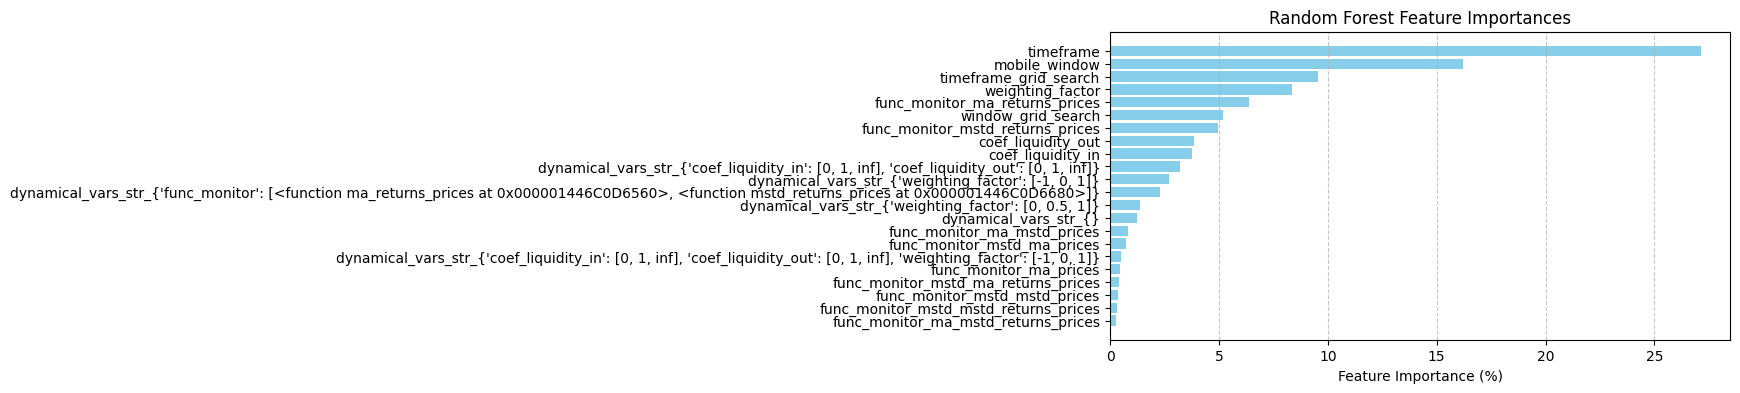

In [55]:
# (dopo aver generato total_results, ad esempio)
model, df_prep = run_training_with_dynamical_vars(total_results)

# df_prep avrà le colonne one-hot (fra cui dynamical_vars_str_...), e potrai vedere
# la feature importance anche su "dynamical_vars_str_{...}"

In [56]:
total_results['dynamical_variables'].value_counts()

dynamical_variables
{'weighting_factor': [-1, 0, 1]}                                                                                                432
{}                                                                                                                              400
{'weighting_factor': [0, 0.5, 1]}                                                                                               320
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf]}                                                           216
{'func_monitor': [<function ma_returns_prices at 0x000001446C0D6560>, <function mstd_returns_prices at 0x000001446C0D6680>]}    108
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'weighting_factor': [-1, 0, 1]}                            20
Name: count, dtype: int64

## Reti neurali

In [57]:
def train_neural_network_regressor(
    df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    train_pct: float = 0.6,
    val_pct: float = 0.2,
    random_state: int = 42,
    network_width: int = 64,
    network_depth: int = 3,
    activation_function: str = 'relu',
    patience: int = 10,
    epochs: int = 100,
    batch_size: int = 32,
    monitor: str = 'val_loss',
    loss: str = 'mse'
):
    """
    Allena una rete neurale per predire il valore continuo in `target_col` a partire dalle feature in `feature_cols`.
    I dati vengono suddivisi in train, validation e test in base ai parametri train_pct e val_pct.
    
    Parametri
    ----------
    df : pd.DataFrame
        DataFrame contenente le feature e il target.
    feature_cols : list
        Lista dei nomi delle colonne feature.
    target_col : str
        Nome della colonna target.
    train_pct : float, default 0.6
        Percentuale dei dati da usare per il training.
    val_pct : float, default 0.2
        Percentuale dei dati da usare per la validazione (il test set sarà 1 - train_pct - val_pct).
    random_state : int, default 42
        Seed per la riproducibilità.
    network_width : int, default 64
        Numero di neuroni in ogni strato hidden.
    network_depth : int, default 3
        Numero di strati hidden.
    activation_function : str, default 'relu'
        Funzione di attivazione da usare nei layer hidden.
    patience : int, default 10
        Numero di epoche da attendere prima di fermare l’allenamento in caso di mancato miglioramento (early stopping).
    epochs : int, default 100
        Numero massimo di epoche per l’allenamento.
    batch_size : int, default 32
        Dimensione del batch per l’allenamento.
    
    Ritorna
    --------
    model : tf.keras.Model
        Il modello neurale addestrato.
    history : tf.keras.callbacks.History
        L’oggetto history con le metriche di training.
    metrics_dict : dict
        Dizionario contenente MAE e MAPE (oltre a eventuali altre metriche) su train, validation e test.
    """
    # Estrai feature e target
    X = df[feature_cols].values
    y = df[target_col].values

    # Calcola la dimensione dei dataset
    test_pct = 1.0 - train_pct - val_pct
    if test_pct <= 0:
        raise ValueError("La somma di train_pct e val_pct deve essere minore di 1.0.")

    # Suddividi in train+val e test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_pct, random_state=random_state
    )
    # Ora, dividi X_train_val in train e validation
    relative_val_pct = val_pct / (train_pct + val_pct)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=relative_val_pct, random_state=random_state
    )

    # Costruisci il modello neurale
    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    # Layer di output: 1 neurone, attivazione lineare
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss=loss, metrics=['mae', 'mape'])

    # Configura l'early stopping
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    # Allena il modello
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Valutazione sui tre set
    train_loss, train_mae, train_mape = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_mae, val_mape = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=0)

    metrics_dict = {
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

    # Plot dei grafici di training
    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Metriche finali:")
    print(metrics_dict)

    return model, history, metrics_dict

In [58]:
def normalize_dynamical_vars_dict(d: dict) -> str:
    """
    Dato un dizionario `d` (es: {'func_monitor': [<function ma_returns_prices>, <function mstd_prices>],
                                'coef_liquidity_in': [0, inf]},
    costruisce una stringa canonica, in cui:
      - le chiavi sono in ordine alfabetico;
      - ogni valore (che e' *sempre* una lista) viene ordinato come stringhe;
      - i Callable vengono sostituiti col loro nome (.__name__),
      - i float speciali (inf) vengono convertiti in "inf",
      - e si genera uno spacing coerente.

    Esempio:
      {'func_monitor': [mstd_prices, ma_returns_prices], 'coef_liquidity_in': [1, inf]}
      => "{'coef_liquidity_in': [1, inf], 'func_monitor': [ma_returns_prices, mstd_prices]}"

    NOTA: se la chiave e' vuota o la lista e' vuota, la salviamo comunque, p.es. "'chiave': []"
    """

    # 1) Copia "logica" del dict (per non modificare l'originale).
    d_copy = dict(d)

    # 2) Creiamo una mappa (key -> string list) da cui costruire poi la stringa
    str_map = {}
    for k_raw, v_raw in d_copy.items():
        # Convertiamo la chiave in str (in genere e' gia' str)
        k = str(k_raw)

        # v_raw e' *sempre* una lista (da ipotesi).
        if not isinstance(v_raw, list):
            # Se per qualche ragione non e' una list, lo trasformiamo in lista con un solo elem
            v_list = [v_raw]
        else:
            v_list = v_raw

        # Ora convertiamo i suoi elementi in string in modo coerente
        converted_elems = []
        for elem in v_list:
            if callable(elem):
                # Funzione => usiamo elem.__name__
                converted_elems.append(elem.__name__)
            elif isinstance(elem, (int, float)):
                if str(elem) == 'inf':
                    converted_elems.append('inf')
                elif str(elem) == '-inf':
                    converted_elems.append('-inf')
                else:
                    converted_elems.append(str(elem))
            else:
                # Altri tipi (str, None, ecc.)
                converted_elems.append(str(elem))

        # Ordiniamo la lista di stringhe
        converted_elems.sort()
        str_map[k] = converted_elems

    # 3) Ordiniamo le chiavi e costruiamo la stringa finale
    sorted_keys = sorted(str_map.keys())
    parts = []
    for k in sorted_keys:
        # costruiamo p.es. "'coef_liquidity_in': [1,inf]"
        lista = str_map[k]
        # costruiamo "val1,val2,val3" senza spazi
        joined_vals = ",".join(lista)
        part = f"'{k}': [{joined_vals}]"
        parts.append(part)

    joined = ", ".join(parts)
    final_str = f"{{{joined}}}"
    return final_str


def flatten_dynamical_variables(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Trasforma la colonna 'col_name' (che contiene sempre un dict,
    i cui valori sono SEMPRE liste di possibili tipi eterogenei)
    in una singola colonna 'dynamical_vars_str' di tipo string,
    uniformata con normalize_dynamical_vars_dict().

    Se per qualche riga 'col_name' non e' un dict, lo convertiamo in str() generica.
    """

    new_col_name = "dynamical_vars_str"
    new_col_values = []

    for val in df[col_name]:
        if isinstance(val, dict):
            # Normalizziamo il dict
            s = normalize_dynamical_vars_dict(val)
            new_col_values.append(s)
        else:
            # Non e' un dict (puo' essere None, o un residuo)
            new_col_values.append(str(val))

    df_out = df.copy()
    df_out[new_col_name] = new_col_values
    df_out.drop(columns=[col_name], inplace=True)
    return df_out

def run_training_with_dynamical_vars(risultati_df_ordinati):
    """
    Esempio di pipeline che:
      1) Converte la colonna 'dynamical_variables' in 'dynamical_vars_str'
         con normalizzazione.
      2) (Opzionale) Trasforma 'func_monitor' in stringa se esiste.
      3) Identifica tutte le colonne object (comprese dynamical_vars_str e func_monitor)
         e le One-Hot-encoda.
      4) Esegue la train_random_forest_regressor (R^2 e feature importance).
    """
    # 1) Flatten la colonna "dynamical_variables" => 'dynamical_vars_str'
    df_flat = flatten_dynamical_variables(risultati_df_ordinati, 'dynamical_variables')

    # 2) Se c'e' la colonna 'func_monitor', la convertiamo in string (nome funzione)
    if 'func_monitor' in df_flat.columns:
        df_flat['func_monitor'] = df_flat['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else str(x)
        )

    # 3) Trova colonne di tipo object su cui fare one-hot
    cat_cols = []
    for c in df_flat.columns:
        if df_flat[c].dtype == object:
            cat_cols.append(c)

    # Escludi eventuali target object
    target_cols = ['fattore_rendimento_totale', 'volatility',
                   'calmar_ratio', 'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    cat_cols = [c for c in cat_cols if c not in target_cols]

    # 4) One-hot encoding
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    arr_encoded = oh.fit_transform(df_flat[cat_cols].astype(str))
    oh_cols = oh.get_feature_names_out(cat_cols)

    df_enc = pd.DataFrame(arr_encoded, columns=oh_cols, index=df_flat.index)

    # Concateniamo
    df_prep = pd.concat([df_flat.drop(columns=cat_cols), df_enc], axis=1)

    # 5) Selezioniamo le feature e il target
    target = 'fattore_rendimento_totale'
    exclude = ['fattore_rendimento_totale', 'volatility', 'calmar_ratio',
               'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    feature_cols = [c for c in df_prep.columns if c not in exclude]

    # Fisso varie cose per garantire la riproducibilità dei risultati

    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.config.experimental.enable_op_determinism()
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

    # 6) Allena la Random Forest
    model = train_neural_network_regressor(
        df=df_prep,
        feature_cols=feature_cols,
        target_col=target,
        train_pct = 0.6,
        val_pct = 0.2,
        random_state = SEED,
        network_width = 1024,
        network_depth = 4,
        activation_function = 'sigmoid',
        patience = 10,
        epochs = 10000,
        batch_size = 32,
        monitor = 'val_mape',
        loss = 'mape'
    )

    return model, df_prep

c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Giochi e simulazioni\Simulazioni\Simulatore di compravendita\Analisi Bitcoin\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 16443.3027 - mae: 65.5938 - mape: 262.3842 - val_loss: 14026.5029 - val_mae: 60.9765 - val_mape: 424.9712
Epoch 2/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 14612.7354 - mae: 64.0171 - mape: 547.8137 - val_loss: 13252.1807 - val_mae: 62.1795 - val_mape: 590.9888
Epoch 3/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 13900.5518 - mae: 65.9409 - mape: 735.7034 - val_loss: 12865.0146 - val_mae: 64.1918 - val_mape: 722.5842
Epoch 4/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 13544.4229 - mae: 68.4603 - mape: 881.9100 - val_loss: 12701.1250 - val_mae: 66.4215 - val_mape: 820.0684
Epoch 5/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 13389.7334 - mae: 70.8750 - mape: 988.2278 - val_loss: 12647.1943 - val_mae: 68.1394 - val_mape: 886.1913
Epoch 6/10000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 13333.9902 - mae: 72.6584 - mape: 1059.1309 - val_loss: 12636.6484 - val_mae: 69.3504 - val_mape: 

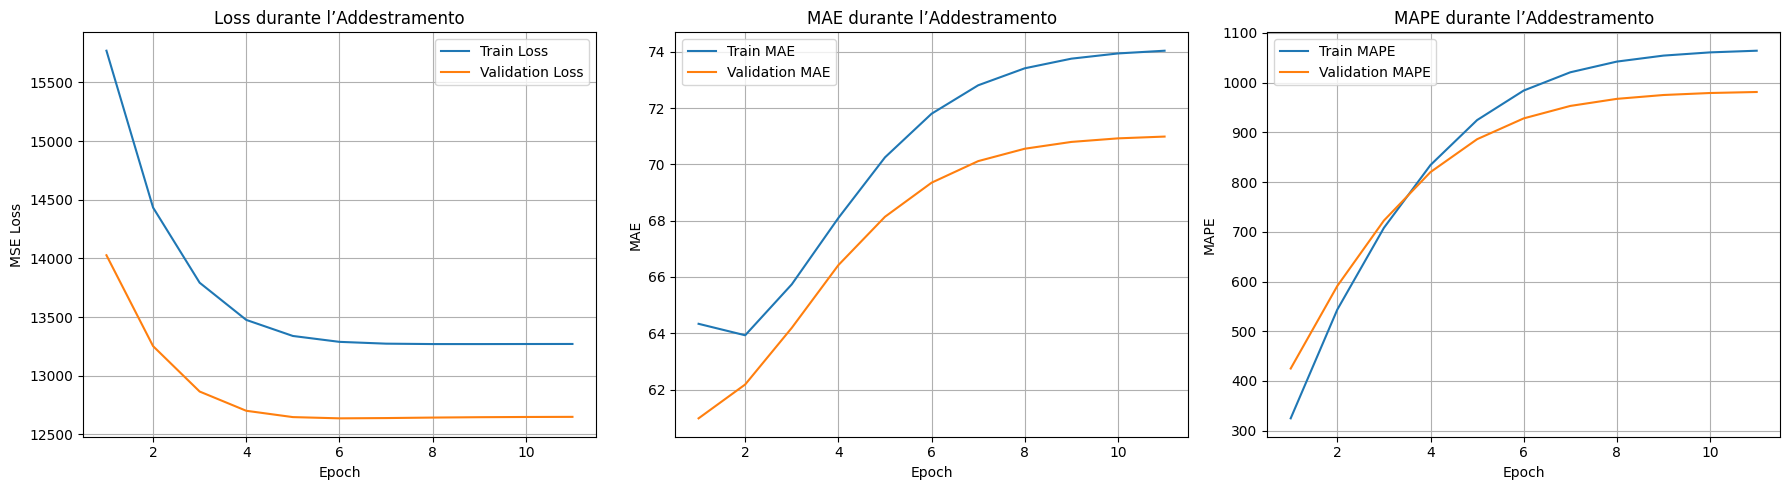

Metriche finali:
{'train_loss': 14881.4814453125, 'train_mae': 63.58333206176758, 'train_mape': 460.760498046875, 'val_loss': 14026.5029296875, 'val_mae': 60.97654342651367, 'val_mape': 424.9712219238281, 'test_loss': 11688.9267578125, 'test_mae': 59.114356994628906, 'test_mape': 526.8798828125}
df_prep:


coef_liquidity_in  coef_liquidity_out  mobile_window  timeframe  \
0                     1                   1             48        336   
1                     5                   1            336        336   
2                     1                   1            336        336   
3                     5                   1            336        336   
4                     1                   1            336        336   
...                 ...                 ...            ...        ...   
1479                  5                   5             48        336   
1480                  5                   5             48        168   
1481                  5                   1             48        168   
1482                  5                   5             48        168   
1483                  5                   1             48        168   

      timeframe_grid_search  weighting_factor  window_grid_search  \
0                        24                 0                 720   
1                       168                 0                 360   
2                       168                 0                 360   
3                        24                 0                 360   
4                        24                 0                 360   
...                     ...               ...                 ...   
1479                     -1                 0                 360   
1480                     -1                 0                 720   
1481                     -1                 0                 720   
1482                     -1                 1                 360   
1483                     -1                 1                 360   

      fattore_rendimento_totale  volatility  max_drawdown  sharpe_ratio  \
0                    908.494398    0.338154     68.194708      0.744260   
1                    752.989043    0.305012     63.960810      0.777325   
2                    732.949699    0.304468     63.960810      0.775615   
3                    683.167978    0.303894     63.960810      0.769824   
4                    664.966256    0.303348     63.960810      0.768096   
...                         ...         ...           ...           ...   
1479                   1.006958    0.157697     65.762144      0.079378   
1480                   0.622838    0.201404     83.896958      0.032621   
1481                   0.610672    0.203551     84.952063      0.031871   
1482                   0.545413    0.288911     87.269260      0.075642   
1483                   0.497671    0.297587     88.383640      0.073287   

      sortino_ratio  calmar_ratio  func_monitor_ma_mstd_prices  \
0          1.338903   1330.740203                          0.0   
1          1.349248   1175.702811                          0.0   
2          1.344309   1144.372152                          0.0   
3          1.334817   1066.540554                          0.0   
4          1.329865   1038.082937                          0.0   
...             ...           ...                          ...   
1479       0.121880      0.010580                          0.0   
1480       0.048315     -0.449554                          0.0   
1481       0.046876     -0.458292                          0.0   
1482       0.124756     -0.520901                          0.0   
1483       0.119883     -0.568351                          0.0   

      func_monitor_ma_mstd_returns_prices  func_monitor_ma_prices  \
0                                     0.0                     0.0   
1                                     0.0                     0.0   
2                                     0.0                     0.0   
3                                     0.0                     0.0   
4                                     0.0                     0.0   
...                                   ...                     ...   
1479                                  1.0                     0.0   
1480                                  1.0             

In [ ]:
model, df_prep = run_training_with_dynamical_vars(total_results)
print('df_prep:')
df_prep